# Advanced Statistical Inference -- MCMC for Bayesian Logistic Regression


In this notebook, you will learn how to 

- Implement the MH algorithm,
- Use it to compute classification probabilities.
- Understand how to run diagnostics on MCMC runs

# 1. Model and data

In this lab, you’re going to implement the Metropolis-Hasting algorithm described in the lecture for binary classification.

In [2]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as scipy
import scipy.spatial

import matplotlib 
import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)

**Exercise:** 
Load and plot the data using `np.loadtxt()`.

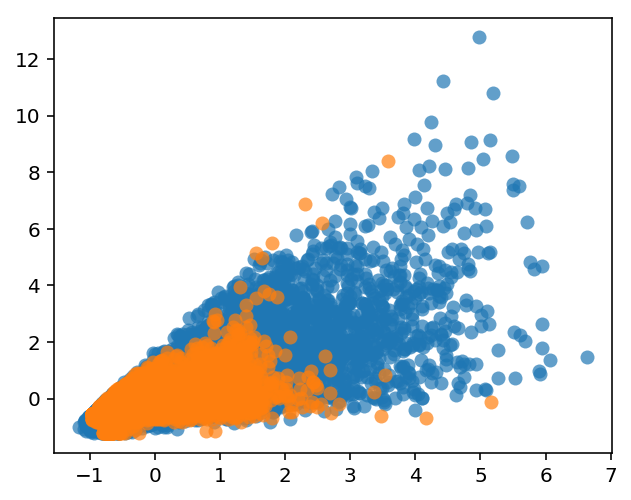

In [5]:
def plot_data(X, y, fmt0='oC0', fmt1='oC1', ax=None):
    mask = y[:, 0]==1
    if ax is None:
        ax = plt.gca()
    ax.plot(X[mask, 0], X[mask, 1], fmt0, ms=7, mew=0, alpha=0.7, zorder=0)
    ax.plot(X[np.logical_not(mask), 0], X[np.logical_not(mask), 1], fmt1, ms=7, mew=0, alpha=0.7, zorder=0)
    return ax

data = np.loadtxt('magic.csv',delimiter=",")
X = data[...,:-1]
y = data[...,-1].reshape(-1,1)

fig, ax = plt.subplots(figsize=[5, 4])
plot_data(X, y, ax=ax)

For logistic regression (binary), we use the logistic (or sigmoid) function defined like $h(z) = (1+\exp(-z))^{-1}$.

**Exercise:**
Implement the logistic function and plot it.

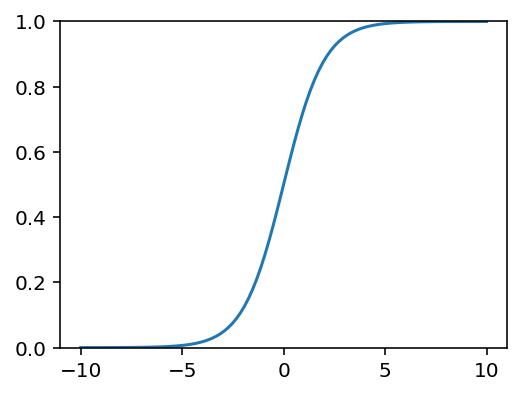

In [6]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 100)
fig, ax = plt.subplots(figsize=[4, 3])
ax.plot(z,logistic(z))
ax.set_ylim(0, 1)
plt.show()

The likelihood that we will use is the *Bernoulli likelihood*. Its logdensity is defined as follows

\begin{align}
\log p(\mathbf{y}|\mathbf{p}) = \mathbf{y} \log(\mathbf{p}) + (1 - \mathbf{y}) \log(1 - \mathbf{p})
\end{align}

where $\mathbf{y}$ is the target class [0, 1] and $\mathbf{p}$ are the predictive probabilities (i.e. the output of the logistic regression).

**Exercise:**
Complete the following class to compute the Bernoulli loglikelihood.

**Exercise:**
Complete also the code for computing the Gaussian logdensity with zero mean and diagonal covariance (check the previous labs).

In [85]:
class BernoulliLikelihood():
    def logdensity(self, y, p):
        return np.sum(y * np.log(p) + (1-y) * np.log(1-p))
    
class NormalPrior():
    def __init__(self, sigma2x):
        self.sigma2x = sigma2x
        
    def logdensity(self, x):
        return (np.exp(-(x)**2/(2*sigma2x**2))/(sigma2x*np.sqrt(np.pi*2)))

# 2. Metropolis-Hastings

Check the lecture notes for the full analysis of the sampler. Below you will find just a summary:

1. Produces a sequence of samples – $\mathbf{w}_1, \mathbf{w}_2, \dots, \mathbf{w}_s, \dots$
- Imagine we’ve just produced $\mathbf{w}_{s-1}$
- MH firsts proposes a possible $\mathbf{w}_s$ (call it $\mathbf{\tilde w}_s$) based on $\mathbf{w}_{s-1}$.
- MH then decides whether or not to accept wfs
    - If accepted, $\mathbf{w}_s \leftarrow \mathbf{\tilde w}_s$
    - If not, $\mathbf{w}_s \leftarrow \mathbf{w}_{s-1}$

We need to treat $\mathbf{\tilde w}_s$ as a random variable conditioned on $\mathbf{w}_{s-1}$. We can choose whatever we like but a simple solution is to use a Gaussian centered on  $\mathbf{w}_{s-1}$ with some covariance $\mathbf{\Sigma}_p$. 

Regarding the acceptance, we need to compute the acceptance ratio. Check the lecture notes for the full derivation.
The first thing that we need to compute is the un-normalized logposterior (i.e. the sum of loglikelihood and prior):

\begin{align}
\log p(\mathbf{w}|\mathbf{X},\mathbf{y}) \propto \log p(\mathbf{y}|\mathbf{w}, \mathbf{X}) + \log p(\mathbf{w}) := g(\mathbf{w}; \mathbf{X}, \mathbf{y})
\end{align}

**Exercise:**
Complete the class below with the code to compute the unnormalized logdensity $g(\mathbf{w}; \mathbf{X}, \mathbf{y})$.

**Exercise:**
Now you can move to the actual MH step. Complete the `step()` function following the flowchart in the slides. Use `self._samples` as buffer for all your samples.

In [122]:
class MHSampler():
    @property
    def samples(self):
        return self._samples
    @samples.getter    
    def samples(self):
        return np.asarray(self._samples)
    
    def __init__(self, initial_sample, likelihood, prior):
        self.likelihood = likelihood
        self.prior = prior
        self._samples = [initial_sample]
        
        
    def unnormalized_logposterior(self, w, X, y):
        log_likelihood = np.sum(self.likelihood.logdensity(y, logistic(X)))
        log_prior = np.sum(self.prior.logdensity(w))
        return log_likelihood + log_prior

    def step(self, X, y, step_proposal):
        w_prev = self._samples[-1]
        w_proposal = 1 * np.random.randn() + w_prev
        
        log_gw_prev = self.unnormalized_logposterior(w_prev, X, y)
        log_gw_proposal = self.unnormalized_logposterior(w_proposal, X, y)
        acceptance_ratio = log_gw_proposal / log_gw_prev
        
        
        if acceptance_ratio >= 1:
            self._samples.append(w_proposal)
        else:
            u = np.random.uniform(0, 1) 
            if u <= acceptance_ratio:
                self._samples.append(w_proposal)
            else:
                self._samples.append(w_prev)
        
        return min(acceptance_ratio, 1)

**Exercise:**
Create the likelihood, the prior (with unit variance) and the sampler.

In [123]:
set_seed()
sigma2x = 1

likelihood = BernoulliLikelihood()
prior = NormalPrior(sigma2x)

starting_point = np.sum(logistic(X))/X.shape[0]
sampler = MHSampler(starting_point, likelihood, prior)

**Exercise:**
Run the sampler for 10000 steps (you can fix the step size for the proposal to 0.5).

In [124]:
set_seed()

for _ in range(10000):
    sampler.step(X,y,0.5)

**Exercise:**
Plot the samples and their distribution.

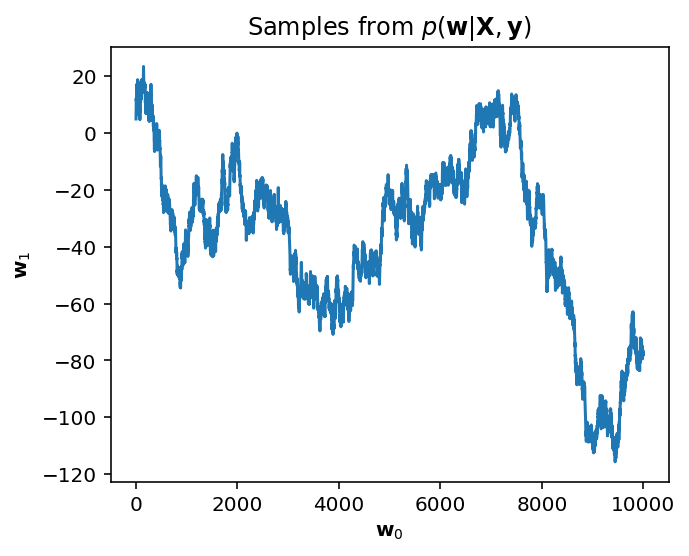

In [125]:
fig, ax = plt.subplots(figsize=[5, 4])
ax.plot(sampler.samples)
ax.set_xlabel(r'$\mathbf{w}_0$')
ax.set_ylabel(r'$\mathbf{w}_1$')
ax.set_title('Samples from $p(\mathbf{w}|\mathbf{X},\mathbf{y}) $')
plt.show()

Now, we can make predictions. 
Remember that our motivation for being Bayesian was to be able to average predictions at $\mathbf{x}_\mathrm{new}$, for all possible $\mathbf{w}$.
This is possible by computing the following expectation:

\begin{equation}
\mathbf{E}_{p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n})}h(\mathbf{w}^\top\mathbf{x}_\mathrm{new}) = \int h(\mathbf{w}^\top\mathbf{x}_\mathrm{new}) p(\mathbf{w}|\mathbf{X}, \mathbf{y}) \mathrm{d}\mathbf{w}
\end{equation}

**Exercise:**
Complete the next function to compute this expectation. And compute the probability $P (y_\mathrm{new} = 1 | \mathbf{x}_\mathrm{new}, \mathbf{X}, \mathbf{y})$ when $\mathbf{x}_\mathrm{new} = [2,-4]^\top$ . 


In [135]:
def predict(x_new, w_samples):
    return np.sum(logistic(np.array([w_samples]).T.dot(np.array([x_new]))))

In [136]:
predict(np.array([2,-4]), sampler.samples)

10002.892002338613

**Exercise:**
Now predict on a grid of points and plot the predictive probabilities (use the two helper function below).

In [ ]:
def get_grid():
    x_grid = np.linspace(-7, 7, 100)
    xx, yy = np.meshgrid(x_grid, x_grid)
    X_plot = np.vstack((xx.flatten(),yy.flatten())).T
    return xx, yy, X_plot

def plot_decision_boundary(xx, yy, P, ax=None):   
    if ax is None:
        ax = plt.gca()
    levels = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
    cs = ax.contour(xx, yy, P.reshape(*xx.shape), levels,  colors='k', linewidths=1.8, zorder=100);
    ax.clabel(cs, inline=1, fontsize=10)
    cs = ax.contourf(xx, yy, P.reshape(*xx.shape), levels, cmap='Purples_r', linewidths=0, zorder=0, alpha=0.5);
    

xx, yy, X_grid = ## *** TO COMPLETE *** ##
ps = predict## *** TO COMPLETE *** ##

fig, ax = plt.subplots(figsize=[5, 4])
plot_decision_boundary(xx, yy, ps, ax=ax)
plot_data(X, y, ax=ax )

ax.set_xlabel(r'$\mathbf{x}_0$')
ax.set_ylabel(r'$\mathbf{x}_1$')
ax.grid(None)
plt.show()

# 3. Assessing convergence of MCMC

Now that the MCMC sampler is done and working, we can move to some analysis.
If your algorithm is designed properly, the Markov chain will converge to the target distribution after *infinite* iterations.
We need to decide when is it wise to make inferences based on a finite Markov chain.
Assessing the convergence of your MCMC is essential if you want to:

- Base your conclusions on posterior distributions
- Report accurate parameter estimates & uncertainties
- Avoid fooling yourself
- Avoid devoting resources to follow-up an “inference” that isn’t supported by data
- Avoid writing an erratum to your homework

## 3.1 Burn-in

**Exercise:**
Sometimes choosing the initial point to start the MCMC is not easy. Choose some very wrong poins (say $[-4, -4]^\top$) and run the sampler for 10000 (set the step size to 0.1).
Plot the trajectory of the first 200s steps with a different color. What do you observe?

In [ ]:
set_seed()

likelihood = BernoulliLikelihood()
prior = NormalPrior(1.)

initial_point = ## *** TO COMPLETE *** ##

sampler = MHSampler(initial_point, likelihood, prior)

for it in range(10000):
    ## *** TO COMPLETE *** ##

fig, ax = plt.subplots(figsize=[5, 4])
ax.plot ## *** TO COMPLETE *** ##
ax.plot ## *** TO COMPLETE *** ##
ax.set_xlabel(r'$\mathbf{w}_0$')
ax.set_ylabel(r'$\mathbf{w}_1$')
ax.set_title('Samples from $p(\mathbf{w}|\mathbf{X},\mathbf{y}) $')
plt.show()

This effect can be mitigated by using burn-in.
Burn-in is intended to give the Markov Chain time to reach its equilibrium distribution, particularly if it has started from a lousy starting point. To "burn in" a chain, you just discard the first $n$ samples before you start collecting points.

The idea is that a "bad" starting point may over-sample regions that are actually very low probability under the equilibrium distribution before it settles into the equilibrium distribution. If you throw those points away, then the points which should be unlikely will be suitably rare.

It clear that the burn-in is more of a hack/artform than a principled technique. In theory, you could just sample for a really long time or find some way to choose a decent starting point instead. 

## 3.2 Trace plots

The trace plot shows the sampled values of a parameter over time (iterations). This plot helps you to judge how quickly the MCMC procedure converges in distribution—that is, how quickly it forgets its starting values.

**Exercise:**
For the two parameters of $\mathbf{w}$, plot their trace. Try to decrease the step parameter, start from 0.5 and go down to 0.01. What do you observe?

In [ ]:
set_seed()
initial_point = np.random.randn(2, 1)

fig, axs = plt.subplots(6, 1, figsize=[10, 12], sharex=True)

sampler = ## *** TO COMPLETE *** ##
## *** TO COMPLETE *** ##
axs[0].plot(sampler.samples[..., 0, 0], '.-', ms=3, lw=.2, color='xkcd:windows blue')
axs[1].plot(sampler.samples[..., 1, 0], '.-', ms=3, lw=.2, color='xkcd:windows blue')
axs[0].set_ylabel(r'$\mathbf{w}_0$')
axs[1].set_ylabel(r'$\mathbf{w}_1$')
axs[0].set_title('Step 0.5')

sampler = ## *** TO COMPLETE *** ##
## *** TO COMPLETE *** ##
axs[0+2].plot(sampler.samples[..., 0, 0], '.-', ms=3, lw=.2, color='xkcd:amber')
axs[1+2].plot(sampler.samples[..., 1, 0], '.-', ms=3, lw=.2, color='xkcd:amber')
axs[0+2].set_ylabel(r'$\mathbf{w}_0$')
axs[1+2].set_ylabel(r'$\mathbf{w}_1$')
axs[2].set_title('Step 0.1')

sampler = ## *** TO COMPLETE *** ##
## *** TO COMPLETE *** ##
axs[0+4].plot(sampler.samples[..., 0, 0], '.-', ms=3, lw=.2, color='xkcd:dusty purple')
axs[1+4].plot(sampler.samples[..., 1, 0], '.-', ms=3, lw=.2, color='xkcd:dusty purple')
axs[0+4].set_ylabel(r'$\mathbf{w}_0$')
axs[1+4].set_ylabel(r'$\mathbf{w}_1$')
axs[4].set_title('Step 0.01')

plt.show()

## 3.2 A more sophisticated diagnostics: $\hat{R}$ - statistics

In an attempt to assuage concerns of poor convergence, we typically run multiple independent chains to see if the
obtained distribution is similar across chains. We can also visually inspect the sample paths of the chains via trace plots
as well as study summary statistics such as the empirical autocorrelation function.

**Exercise:** 
Complete the following function to run multiple chain (you can use `multiprocessing` for an actual parallel implementation, but it's not required here).

In [ ]:
def run_chains(num_chains, steps, step_size=.5):
    def run_single_chain(steps):
        initial_point = ## *** TO COMPLETE *** ##
        sampler = ## *** TO COMPLETE *** ##
        ## *** TO COMPLETE *** ##
        return sampler.samples[...,0]
    
    samples = ## *** TO COMPLETE *** ##
    return np.stack(samples)

**Exercise:**
Sample now from multiple independent chains and plot the traces (use a step size of 0.5, you can try different configurations if you have time).

In [ ]:
set_seed()

samples = ## *** TO COMPLETE *** ##

fig, axs = plt.subplots(2, 1, figsize=[10, 4], sharex=True)
axs[0].plot(samples[..., 0].T, '.-', ms=3, lw=.2,)
axs[1].plot(samples[..., 1].T, '.-', ms=3, lw=.2,)
axs[0].set_ylabel(r'$\mathbf{w}_0$')
axs[1].set_ylabel(r'$\mathbf{w}_1$')
axs[0].set_title('Trace plot with multiple chains')
plt.show()

Of the various convergence diagnostics, probably the most widely used is the **potential scale reduction factor** $\hat R$.
It is recommended as the primary convergence diagnostic in widely applied software
packages for MCMC sampling such as Stan (Carpenter et al., 2017), JAGS (Plummer, 2003), WinBUGS (Lunn et al.,
2000), OpenBUGS (Lunn et al., 2009), PyMC3 (Salvatier et al., 2016), and NIMBLE (de Valpine et al., 2017), which
together are estimated to have hundreds of thousand of users. 
$\hat R$ is computed for each scalar quantity of interest, as the standard deviation of that quantity from all the chains included together, divided by the root mean square of the separate within-chain standard deviations. The idea is that if a set of simulations have not mixed well, the variance
of all the chains mixed together should be higher than the variance of individual chains


At convergence, the chains will have mixed, so that the distribution of the simulations
between and within chains will be identical, and the ratio $\hat R$ should equal 1. If $\hat R$
is greater than 1, this implies that the chains have not fully mixed and that further simulation might increase the precision of inferences. In practice we typically go until $\hat R$ is less than 1.1/1.05 for all parameters.

In [ ]:
def _rhat_base(ary):
    """Compute the rhat for a 2d array."""
    _, num_samples = ary.shape

    # Calculate chain mean
    chain_mean = np.mean(ary, axis=1)
    # Calculate chain variance
    chain_var = np.var(ary, axis=1, ddof=1)
    # Calculate between-chain variance
    between_chain_variance = num_samples * np.var(chain_mean, axis=None, ddof=1)
    # Calculate within-chain variance
    within_chain_variance = np.mean(chain_var)
    # Estimate of marginal posterior variance
    rhat_value = np.sqrt(
        (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
    )
    return rhat_value


def _rhat_rank(ary):
    """Compute the rank normalized rhat. 
    Computation follows https://arxiv.org/abs/1903.08008
    """
    
    def _z_scale(ary):
        rank = scipy.stats.rankdata(ary, method="average")
        z = scipy.stats.norm.ppf((rank - 0.5) / ary.size)
        return z.reshape(ary.shape)
    
    
    def _split_chains(ary):
        """Split and stack chains."""
        _, n_draw = ary.shape
        half = n_draw // 2
        return np.vstack((ary[:, :half], ary[:, -half:]))
    
    split_ary = _split_chains(ary)
    rhat_bulk = _rhat_base(_z_scale(split_ary))

    split_ary_folded = abs(split_ary - np.median(split_ary))
    rhat_tail = _rhat_base(_z_scale(split_ary_folded))

    rhat_rank = max(rhat_bulk, rhat_tail)
    return rhat_rank

def compute_rhat(samples):
    """Compute the rhat statistics from samples. Samples needs to be a tensor 
    with dimensions [num_of_chain, num_of_samples, num_of_variables]. """
    
    samples = np.atleast_3d(samples)
    return np.asarray([_rhat_rank(samples[...,i]) for i in range(samples.shape[-1]) ])

**Exercise:**
Using the function provided above, compute the $\hat R$-statistics for $\mathbf{w}$ with the following parameters:

- num_of_chain = 4
- num_of_samples = [100, 1000, 10000]
- step size = [0.5, 0.1, 0.01]

**Question:**
Comment the results. For which configurations $\hat R$-statistics suggests convergence has not been achieved?

In [ ]:
set_seed()

## *** TO COMPLETE *** ##

**Exercise:**
The $\hat R$-statistics can also be plotted as a function of iteration. Complete the next code cell to visualize its behaviour.
Try also with step size = [0.5, 0.1, 0.01].

In [ ]:
set_seed()

samples = ## *** TO COMPLETE *** ##

steps = np.logspace(1, 4, 10).astype(int)
rhats = ## *** TO COMPLETE *** ##

fig, ax = plt.subplots(figsize=[8,3])
ax.plot(steps, ## *** TO COMPLETE *** ##

ax.fill_between(steps, 0.9, 1.05, color='xkcd:leaf green', alpha=.5, lw=0)
ax.fill_between(steps, 1.05, 1.15, color='xkcd:pumpkin orange', alpha=.5, lw=0)
ax.set_title(r'$\hat R$ vs iterations')
ax.set_ylim(0.9, 2)
ax.legend([r'$\mathbf{w}_0$', r'$\mathbf{w}_1$'])
ax.semilogx()

plt.show()

# 4. A real example: MAGIC dataset (+)

The data is made of 10 features and it's generated to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique.

The objective is to discriminate those caused by primary gammas celestial objects (signal) from the ones generated by cosmic rays scattered in the upper atmosphere (background). 

**Exercise:**
Try to solve this problem. Divide the dataset into train/test set (0.8/0.2). Set up the prior, the likelihood and the sampler. Sample and make sure you reached convergence. Predict the test set and report some metrics (test accuracy and test loglikelihood are the most commonly used).

In [ ]:
set_seed()

data = np.loadtxt('magic.csv', delimiter=',')
data_size = len(data)
data = data[np.random.permutation(data_size)]

X = data[...,:-1]
y = data[...,-1].reshape(-1, 1)

Xtrain, Xtest, ytrain, ytest = ## *** TO COMPLETE *** ##

In [ ]:
set_seed()

initial_point = ## *** TO COMPLETE *** ##
prior = ## *** TO COMPLETE *** ##
likelihood = ## *** TO COMPLETE *** ##
sampler = ## *** TO COMPLETE *** ##

## *** TO COMPLETE *** ##

In [ ]:
ypred = ## *** TO COMPLETE *** ##

test_loglikelihood = ## *** TO COMPLETE *** ##
test_accuracy = ## *** TO COMPLETE *** ##